# Import

In [1]:
import os
import numpy as np
import pandas as pd
from ase.io import read
from dscribe.descriptors import CoulombMatrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPRegressor
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from xgboost import XGBRegressor
from torch.utils.data import TensorDataset
import math
import seaborn as sns

# Import train data

In [2]:
xyz_folder = "./atoms/train"
csv_file = "./energies/train.csv"
n_atoms_max = 23  

energies_df = pd.read_csv(csv_file)
file_ids = energies_df["id"].tolist()
target_values = energies_df["energy"].values

# Create Coulomb matrix train

In [3]:
cm_sorted = CoulombMatrix(n_atoms_max=n_atoms_max, permutation="sorted_l2")
cm_raw = CoulombMatrix(n_atoms_max=n_atoms_max, permutation="none")  

X_raw = []        
X_sorted = []           
X_augmented = []        
y_raw = []
y_sorted = []
y_augmented = []
atom_labels_list = []            

n_augmentations = 5 

for i, mol_id in enumerate(file_ids):
    xyz_path = os.path.join(xyz_folder, f"id_{mol_id}.xyz")
    if os.path.isfile(xyz_path):
        try:
            atoms = read(xyz_path)
            atom_names = atoms.get_chemical_symbols()

            if len(atom_names) < n_atoms_max:
                atom_names += [""] * (n_atoms_max - len(atom_names))
            
            atom_labels_list.append(atom_names)  

            cm_r = cm_raw.create(atoms).reshape((n_atoms_max, n_atoms_max))
            X_raw.append(cm_r)
            y_raw.append(target_values[i])

            cm_s = cm_sorted.create(atoms).reshape((n_atoms_max, n_atoms_max))
            X_sorted.append(cm_s)
            y_sorted.append(target_values[i])

            for _ in range(n_augmentations):
                perm = np.random.permutation(n_atoms_max)
                cm_permuted = cm_r[np.ix_(perm, perm)]
                X_augmented.append(cm_permuted)
                y_augmented.append(target_values[i])

        except Exception as e:
            print(f"Erreur de lecture pour {xyz_path}: {e}")
    else:
        print(f"Fichier manquant : {xyz_path}")


X_raw = np.array(X_raw)
X_sorted = np.array(X_sorted)
X_augmented = np.array(X_augmented)
y_raw = np.array(y_raw)
y_sorted = np.array(y_sorted)
y_augmented = np.array(y_augmented)

scaler = StandardScaler()
X_raw_scaled = scaler.fit_transform(X_raw.reshape(len(X_raw), -1))
X_sorted_scaled = scaler.fit_transform(X_sorted.reshape(len(X_sorted), -1))
X_augmented_scaled = scaler.transform(X_augmented.reshape(len(X_augmented), -1))


# Visualize Coulomb matrix

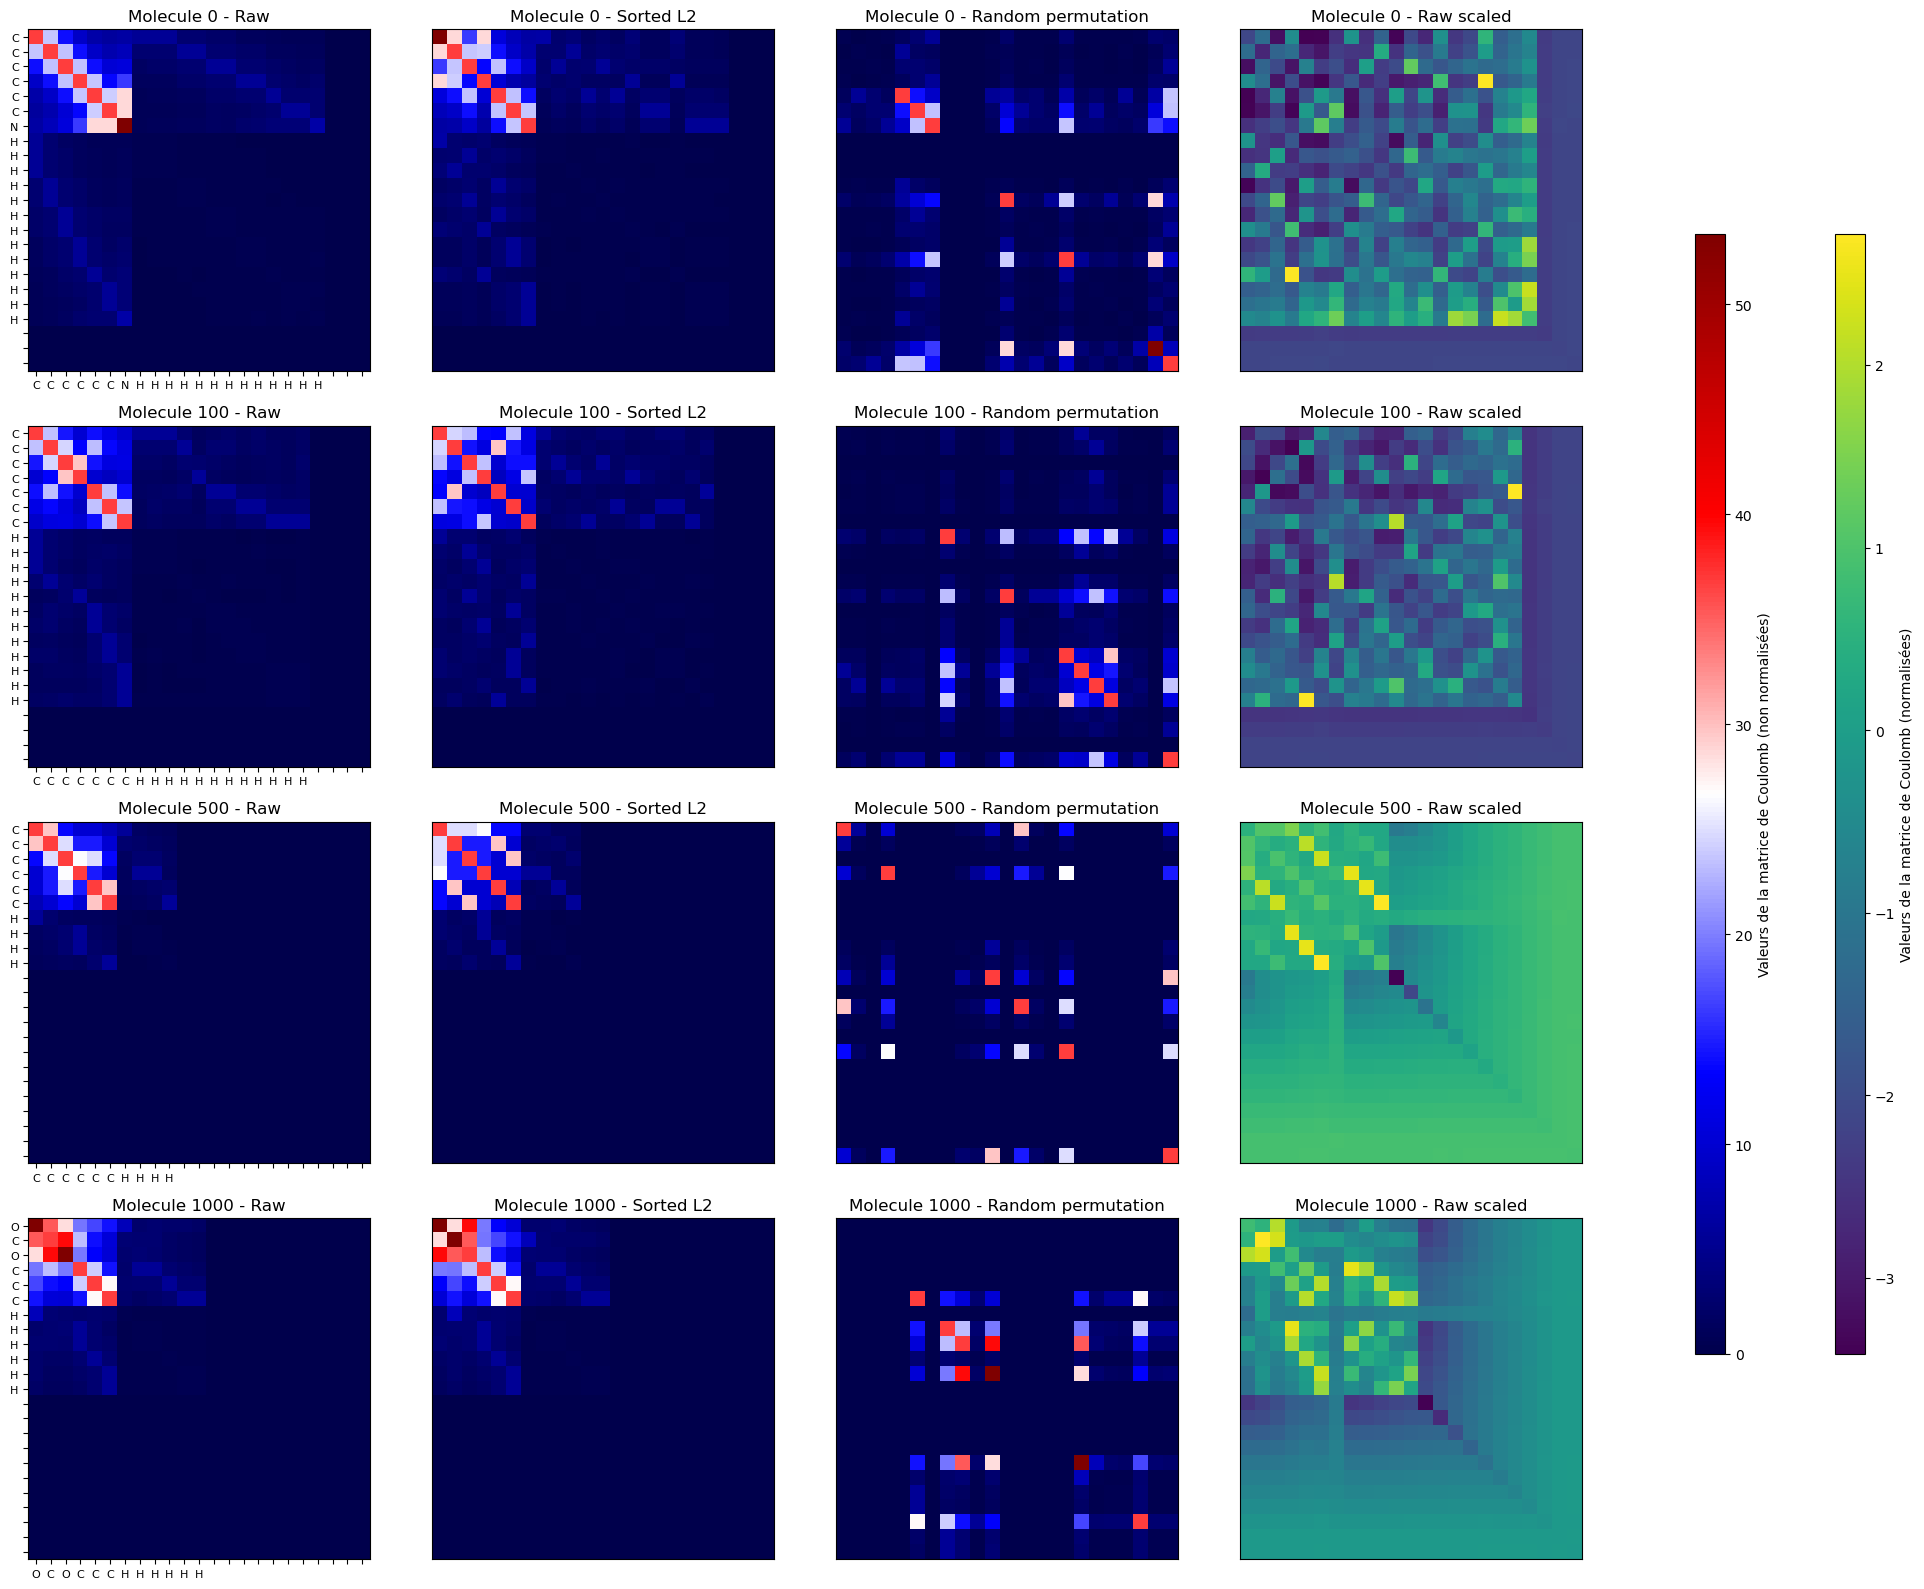

In [4]:
indices = [0, 100, 500, 1000]
n_display = len(indices)
fig, axs = plt.subplots(nrows=n_display, ncols=4, figsize=(20, 4 * n_display))

## échelle pour les 3 premières colonnes (non-scalées)
first_matrix = X_raw[indices[0]]
vmin = np.min(first_matrix)
vmax = np.max(first_matrix)

for row_idx, mol_idx in enumerate(indices):
    labels = atom_labels_list[mol_idx]
    dim = n_atoms_max

    ## RAW
    raw_matrix = X_raw[mol_idx]
    im0 = axs[row_idx, 0].imshow(raw_matrix, cmap='seismic', vmin=vmin, vmax=vmax)
    axs[row_idx, 0].set_title(f"Molecule {mol_idx} - Raw")
    axs[row_idx, 0].set_xticks(np.arange(dim))
    axs[row_idx, 0].set_yticks(np.arange(dim))
    axs[row_idx, 0].set_xticklabels(labels, rotation=0, fontsize=8)
    axs[row_idx, 0].set_yticklabels(labels, fontsize=8)

    ## SORTED
    sorted_matrix = X_sorted[mol_idx]
    axs[row_idx, 1].imshow(sorted_matrix, cmap='seismic', vmin=vmin, vmax=vmax)
    axs[row_idx, 1].set_title(f"Molecule {mol_idx} - Sorted L2")
    axs[row_idx, 1].set_xticks([])
    axs[row_idx, 1].set_yticks([])

    ## RANDOM
    aug_index = mol_idx * n_augmentations
    if aug_index < len(X_augmented):
        random_matrix = X_augmented[aug_index]
        axs[row_idx, 2].imshow(random_matrix, cmap='seismic', vmin=vmin, vmax=vmax)
        axs[row_idx, 2].set_title(f"Molecule {mol_idx} - Random permutation")
        axs[row_idx, 2].set_xticks([])
        axs[row_idx, 2].set_yticks([])

    ## RAW SCALED (échelle indépendante)
    scaled_matrix_flat = X_sorted_scaled[mol_idx]
    scaled_matrix = scaled_matrix_flat.reshape((dim, dim))
    im3 = axs[row_idx, 3].imshow(scaled_matrix, cmap='viridis')  
    axs[row_idx, 3].set_title(f"Molecule {mol_idx} - Raw scaled")
    axs[row_idx, 3].set_xticks([])
    axs[row_idx, 3].set_yticks([])

## Ajustement layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  ## Espace pour colorbars à droite

## Colorbar pour les 3 premières colonnes (non-normalisée)
cbar_ax1 = fig.add_axes([0.87, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(im0, cax=cbar_ax1, label='Valeurs de la matrice de Coulomb (non normalisées)')

## Colorbar pour la colonne normalisée
cbar_ax2 = fig.add_axes([0.94, 0.15, 0.015, 0.7])
fig.colorbar(im3, cax=cbar_ax2, label='Valeurs de la matrice de Coulomb (normalisées)')

plt.show()


# Regression

In [6]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]

results = {
    'Ridge_raw': [],
    'Ridge_sorted': [],            
    'Ridge_augmented': [],

    'Ridge_raw_scaled': [],
    'Ridge_sorted_scaled': [],
    'Ridge_augmented_scaled': [],

    'Lasso_raw': [],
    'Lasso_sorted': [],             
    'Lasso_augmented': [],

    'Lasso_raw_scaled': [],
    'Lasso_sorted_scaled': [],
    'Lasso_augmented_scaled': [],
}

for alpha in alphas:
    ## Ridge - raw (non-scaled)
    ridge_raw = Ridge(alpha=alpha)
    ridge_raw.fit(X_raw.reshape(len(X_raw), -1), y_raw)
    y_pred = ridge_raw.predict(X_raw.reshape(len(X_raw), -1))
    results['Ridge_raw'].append(mean_squared_error(y_raw, y_pred, squared=False))

    ## Ridge - sorted (non-scaled)
    ridge_sorted = Ridge(alpha=alpha)
    ridge_sorted.fit(X_sorted.reshape(len(X_sorted), -1), y_sorted)
    y_pred = ridge_sorted.predict(X_sorted.reshape(len(X_sorted), -1))
    results['Ridge_sorted'].append(mean_squared_error(y_sorted, y_pred, squared=False))

    ## Ridge - augmented random (non-scaled)
    ridge_augmented = Ridge(alpha=alpha)
    ridge_augmented.fit(X_augmented.reshape(len(X_augmented), -1), y_augmented)
    y_pred = ridge_augmented.predict(X_augmented.reshape(len(X_augmented), -1))
    results['Ridge_augmented'].append(mean_squared_error(y_augmented, y_pred, squared=False))


    ## Ridge - raw scaled
    ridge_raw_scaled = Ridge(alpha=alpha)
    ridge_raw_scaled.fit(X_raw_scaled, y_raw)
    y_pred = ridge_raw_scaled.predict(X_raw_scaled)
    results['Ridge_raw_scaled'].append(mean_squared_error(y_raw, y_pred, squared=False))

    ## Ridge - sorted scaled
    ridge_sorted_scaled = Ridge(alpha=alpha)
    ridge_sorted_scaled.fit(X_sorted_scaled, y_sorted)
    y_pred = ridge_sorted_scaled.predict(X_sorted_scaled)
    results['Ridge_sorted_scaled'].append(mean_squared_error(y_sorted, y_pred, squared=False))

    ## Ridge - augmented scaled
    ridge_augmented_scaled = Ridge(alpha=alpha)
    ridge_augmented_scaled.fit(X_augmented_scaled, y_augmented)
    y_pred = ridge_augmented_scaled.predict(X_augmented_scaled)
    results['Ridge_augmented_scaled'].append(mean_squared_error(y_augmented, y_pred, squared=False))


    ## Lasso - raw (non-scaled)
    lasso_raw = Lasso(alpha=alpha, max_iter=1000)
    lasso_raw.fit(X_raw.reshape(len(X_raw), -1), y_raw)
    y_pred = lasso_raw.predict(X_raw.reshape(len(X_raw), -1))
    results['Lasso_raw'].append(mean_squared_error(y_raw, y_pred, squared=False))

    ## Lasso - sorted (non-scaled)
    lasso_sorted = Lasso(alpha=alpha, max_iter=1000)
    lasso_sorted.fit(X_sorted.reshape(len(X_sorted), -1), y_sorted)
    y_pred = lasso_sorted.predict(X_sorted.reshape(len(X_sorted), -1))
    results['Lasso_sorted'].append(mean_squared_error(y_sorted, y_pred, squared=False))

    ## Lasso - augmented random (non-scaled)
    lasso_augmented = Lasso(alpha=alpha, max_iter=1000)
    lasso_augmented.fit(X_augmented.reshape(len(X_augmented), -1), y_augmented)
    y_pred = lasso_augmented.predict(X_augmented.reshape(len(X_augmented), -1))
    results['Lasso_augmented'].append(mean_squared_error(y_augmented, y_pred, squared=False))


    ## Lasso - raw scaled
    lasso_raw_scaled = Lasso(alpha=alpha, max_iter=1000)
    lasso_raw_scaled.fit(X_raw_scaled, y_raw)
    y_pred = lasso_raw_scaled.predict(X_raw_scaled)
    results['Lasso_raw_scaled'].append(mean_squared_error(y_raw, y_pred, squared=False))

    ## Lasso - sorted scaled
    lasso_sorted_scaled = Lasso(alpha=alpha, max_iter=1000)
    lasso_sorted_scaled.fit(X_sorted_scaled, y_sorted)
    y_pred = lasso_sorted_scaled.predict(X_sorted_scaled)
    results['Lasso_sorted_scaled'].append(mean_squared_error(y_sorted, y_pred, squared=False))

    ## Lasso - augmented scaled
    lasso_augmented_scaled = Lasso(alpha=alpha, max_iter=1000)
    lasso_augmented_scaled.fit(X_augmented_scaled, y_augmented)
    y_pred = lasso_augmented_scaled.predict(X_augmented_scaled)
    results['Lasso_augmented_scaled'].append(mean_squared_error(y_augmented, y_pred, squared=False))

/home/sara/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.350e+03, tolerance: 8.949e+01
  model = cd_fast.enet_coordinate_descent(
/home/sara/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.706e+03, tolerance: 8.949e+01
  model = cd_fast.enet_coordinate_descent(
/home/sara/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e+

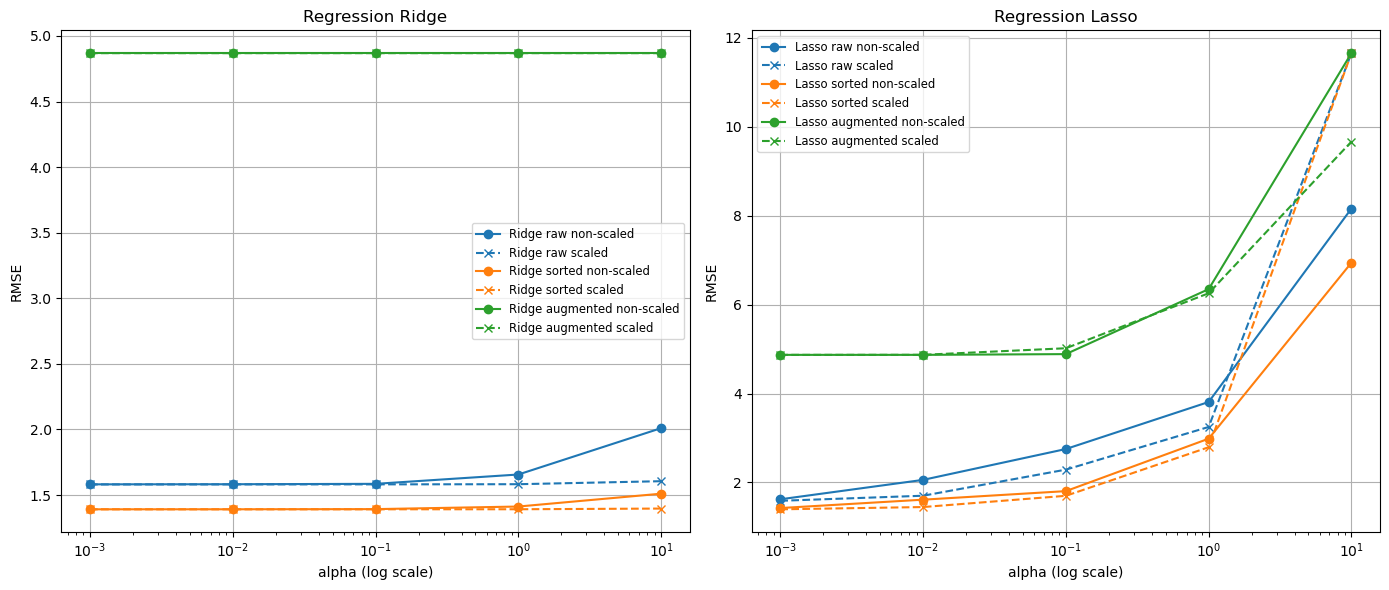

In [8]:
plt.figure(figsize=(14, 6))

colors = ['tab:blue', 'tab:orange', 'tab:green']
linestyles = ['-', '--']  # '-' pour non-scaled, '--' pour scaled

## sous-graphe Ridge
plt.subplot(1, 2, 1)
for i, case in enumerate(['raw', 'sorted', 'augmented']):
    plt.plot(alphas, results[f'Ridge_{case}'], marker='o', color=colors[i], linestyle=linestyles[0], label=f'Ridge {case} non-scaled')
    plt.plot(alphas, results[f'Ridge_{case}_scaled'], marker='x', color=colors[i], linestyle=linestyles[1], label=f'Ridge {case} scaled')

plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('RMSE')
plt.title('Regression Ridge')
plt.grid(True)
plt.legend(fontsize='small')

## sous-graphe Lasso
plt.subplot(1, 2, 2)
for i, case in enumerate(['raw', 'sorted', 'augmented']):
    plt.plot(alphas, results[f'Lasso_{case}'], marker='o', color=colors[i], linestyle=linestyles[0], label=f'Lasso {case} non-scaled')
    plt.plot(alphas, results[f'Lasso_{case}_scaled'], marker='x', color=colors[i], linestyle=linestyles[1], label=f'Lasso {case} scaled')

plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('RMSE')
plt.title('Regression Lasso')
plt.grid(True)
plt.legend(fontsize='small')

plt.tight_layout()
plt.show()

# Random Forest

## sorted_l2

In [10]:
param_grid_rf_sorted = {
    'n_estimators': [10, 25, 50, 100, 200, 400],
    'max_depth': [5, 10, 20, 25]
}

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

rf_sorted = RandomForestRegressor(random_state=42)

grid_search_rf_sorted = GridSearchCV(
    estimator=rf_sorted,
    param_grid=param_grid_rf_sorted,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,  
    verbose=2
)

X_sorted_flat = X_sorted.reshape(len(X_sorted), -1) 

grid_search_rf_sorted.fit(X_sorted_flat, y_sorted)

print("Meilleurs paramètres trouvés :")
print(grid_search_rf_sorted.best_params_)
print(f"Meilleur RMSE (CV) : {-grid_search_rf_sorted.best_score_:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......................max_depth=5, n_estimators=10; total time=   6.3s
[CV] END .......................max_depth=5, n_estimators=10; total time=   6.5s
[CV] END .......................max_depth=5, n_estimators=10; total time=   6.5s
[CV] END .......................max_depth=5, n_estimators=10; total time=   6.7s
[CV] END .......................max_depth=5, n_estimators=10; total time=   6.8s
[CV] END .......................max_depth=5, n_estimators=25; total time=  15.6s
[CV] END .......................max_depth=5, n_estimators=25; total time=  16.0s
[CV] END .......................max_depth=5, n_estimators=25; total time=  16.3s
[CV] END .......................max_depth=5, n_estimators=25; total time=  16.6s
[CV] END .......................max_depth=5, n_estimators=25; total time=  16.9s
[CV] END .......................max_depth=5, n_estimators=50; total time=  32.8s
[CV] END .......................max_depth=5, n_

In [18]:

results_rf_sorted = pd.DataFrame(grid_search_rf_sorted.cv_results_)
results_rf_sorted['mean_rmse'] = -results_rf_sorted['mean_test_score']
results_rf_sorted = results_rf_sorted[['param_n_estimators', 'param_max_depth', 'mean_rmse']]


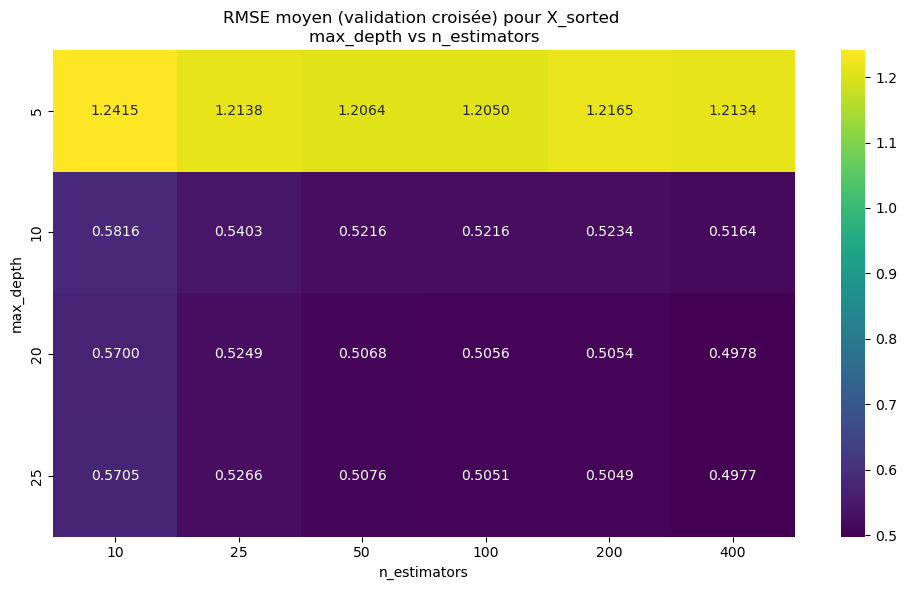

In [22]:
pivot_rf_sorted = results_rf_sorted.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_rmse')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_rf_sorted, annot=True, fmt=".4f", cmap="viridis")
plt.title("RMSE moyen (validation croisée) pour X_sorted \nmax_depth vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()


In [20]:
best_row = results_rf_sorted.loc[results_rf_sorted['mean_rmse'].idxmin()]
print("Meilleurs paramètres :")
print(f" - n_estimators : {best_row['param_n_estimators']}")
print(f" - max_depth    : {best_row['param_max_depth']}")
print(f" - RMSE (CV)    : {best_row['mean_rmse']:.4f}")


Meilleurs paramètres :
 - n_estimators : 400
 - max_depth    : 25
 - RMSE (CV)    : 0.4977


In [5]:
model_rf_sorted = RandomForestRegressor(n_estimators=400, max_depth=25, random_state=42)
X_sorted_flat = X_sorted.reshape(len(X_sorted), -1) 
model_rf_sorted.fit(X_sorted_flat, y_sorted)
y_pred_sorted = model_rf_sorted.predict(X_sorted_flat)
rmse = mean_squared_error(y_sorted, y_pred_sorted, squared=False)
print(f"Random Forest RMSE sorted: {rmse:.4f}")

Random Forest RMSE sorted: 0.1702


## random_sort/augmented

In [24]:
param_grid_rf_augmented = {
    'n_estimators': [10, 25, 50, 100, 200, 400],
    'max_depth': [5, 10, 20, 25]
}

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

rf_augmented = RandomForestRegressor(random_state=42)

grid_search_rf_augmented = GridSearchCV(
    estimator=rf_augmented,
    param_grid=param_grid_rf_augmented,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,  
    verbose=2
)

X_augmented_flat = X_augmented.reshape(len(X_augmented), -1) 

grid_search_rf_augmented.fit(X_augmented_flat, y_augmented)

print("Meilleurs paramètres trouvés :")
print(grid_search_rf_augmented.best_params_)
print(f"Meilleur RMSE (CV) : {-grid_search_rf_augmented.best_score_:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......................max_depth=5, n_estimators=10; total time=  47.1s
[CV] END .......................max_depth=5, n_estimators=10; total time=  48.0s
[CV] END .......................max_depth=5, n_estimators=10; total time=  48.7s
[CV] END .......................max_depth=5, n_estimators=10; total time=  48.5s
[CV] END .......................max_depth=5, n_estimators=10; total time=  51.8s
[CV] END .......................max_depth=5, n_estimators=25; total time= 2.0min
[CV] END .......................max_depth=5, n_estimators=25; total time= 2.1min
[CV] END .......................max_depth=5, n_estimators=25; total time= 2.1min
[CV] END .......................max_depth=5, n_estimators=25; total time= 2.2min
[CV] END .......................max_depth=5, n_estimators=25; total time= 2.2min
[CV] END .......................max_depth=5, n_estimators=50; total time= 3.9min
[CV] END .......................max_depth=5, n_

KeyboardInterrupt: 

In [ ]:

results_rf_augmented = pd.DataFrame(grid_search_rf_augmented.cv_results_)
results_rf_augmented['mean_rmse'] = -results_rf_augmented['mean_test_score']
results_rf_augmented = results_rf_augmented[['param_n_estimators', 'param_max_depth', 'mean_rmse']]


In [ ]:
pivot_rf_augmented = results_rf_augmented.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_rmse')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_rf_augmented, annot=True, fmt=".4f", cmap="viridis")
plt.title("RMSE moyen (validation croisée) pour X_augmented \nmax_depth vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()


In [ ]:
best_row = pivot_rf_augmented.loc[pivot_rf_augmented['mean_rmse'].idxmin()]
print("Meilleurs paramètres :")
print(f" - n_estimators : {best_row['param_n_estimators']}")
print(f" - max_depth    : {best_row['param_max_depth']}")
print(f" - RMSE (CV)    : {best_row['mean_rmse']:.4f}")


In [ ]:
model_rf_augmented = RandomForestRegressor(n_estimators=400, max_depth=25, random_state=42)
X_augmented_flat = X_sorted.reshape(len(X_augmented), -1) 
model_rf_augmented.fit(X_augmented_flat, y_augmented)
y_pred_augmented = model_rf_augmented.predict(X_augmented_flat)
rmse = mean_squared_error(y_augmented, y_pred_augmented, squared=False)
print(f"Random Forest RMSE augmented: {rmse:.4f}")

# Neural network

## instanciation du modèle

In [5]:
bin_step = 1.0
lr = 0.01
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

In [6]:
def binarize_coulomb_matrix(C, theta=bin_step):
    return np.concatenate([
        np.tanh((C - theta) / theta).flatten(),
        np.tanh((C / theta)).flatten(),
        np.tanh((C + theta) / theta).flatten()
    ])

In [7]:
class CoulombMLP(nn.Module):
    def __init__(self, input_dim):
        super(CoulombMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.Sigmoid(),
            nn.Linear(400, 100),
            nn.Sigmoid(),
            nn.Linear(100, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=1 / math.sqrt(layer.in_features))
                nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        return self.net(x)

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y) + self.eps)

## sorted_l2

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entraînement sur : {device}")

Entraînement sur : cuda


In [80]:
## Binarisation, normalisation et préparation des tensors
batch_size = 25

X_bin_sorted = np.array([binarize_coulomb_matrix(C) for C in X_sorted])
scaler_X_sorted = StandardScaler()
scaler_y_sorted = StandardScaler()

# X_scaled_sorted = scaler_X_sorted.fit_transform(X_bin_sorted)
# y_scaled_sorted = scaler_y_sorted.fit_transform(y_sorted.reshape(-1, 1)) #1


# X_tensor_sorted = torch.tensor(X_scaled_sorted, dtype=torch.float32).to(device) #2
X_tensor_sorted = torch.tensor(X_bin_sorted, dtype=torch.float32).to(device)

# y_tensor_sorted = torch.tensor(y_scaled_sorted, dtype=torch.float32).to(device) #1
y_tensor_sorted = torch.tensor(y_sorted.reshape(-1, 1), dtype=torch.float32).to(device)

dataset_sorted = TensorDataset(X_tensor_sorted, y_tensor_sorted)
train_loader_sorted = DataLoader(dataset_sorted, batch_size=batch_size, shuffle=True)

In [82]:
## définition des paramètres du modèle
input_dim_sorted = X_tensor_sorted.shape[1]
model_mlp_sorted = CoulombMLP(input_dim_sorted).to(device)
# optimizer = torch.optim.SGD(model_mlp_sorted.parameters(), lr=lr / np.sqrt(input_dim_sorted))
optimizer = torch.optim.ASGD(model_mlp_sorted.parameters(), lr=lr / np.sqrt(input_dim_sorted))
loss_fn = RMSELoss()
print(input_dim_sorted)

1587


In [83]:
epochs = 1000
train_loss_history_sorted = []

for epoch in tqdm(range(epochs), desc="Entraînement"):
    model_mlp_sorted.train()
    train_loss = 0.0
    
    for xb, yb in train_loader_sorted:
        pred = model_mlp_sorted(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(dataset_sorted)
    train_loss_history_sorted.append(train_loss)

    # tqdm.write(f"[{epoch+1}] Train RMSE: {train_loss:.5f}")


Entraînement: 100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


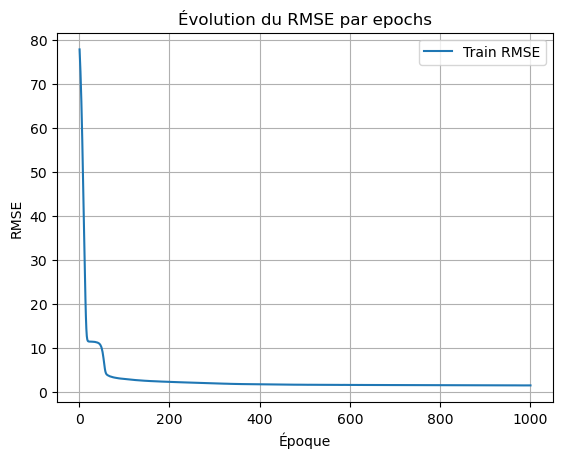

In [86]:
plt.plot(range(1, epochs + 1), train_loss_history_sorted, label="Train RMSE")
plt.xlabel("Époque")
plt.ylabel("RMSE")
plt.title("Évolution du RMSE par epochs")
plt.grid(True)
plt.legend()
plt.show()

In [87]:
model_mlp_sorted.eval()

with torch.no_grad():
    y_pred_sorted = model_mlp_sorted(X_tensor_sorted)

# y_pred_sorted_np = scaler_y_sorted.inverse_transform(y_pred_sorted.cpu().numpy()) #1
# y_true_sorted_np = scaler_y_sorted.inverse_transform(y_tensor_sorted.cpu().numpy()) #1
y_pred_sorted_np = y_pred_sorted.cpu().numpy()
y_true_sorted_np = y_tensor_sorted.cpu().numpy()


rmse_sorted = np.sqrt(np.mean((y_pred_sorted_np - y_true_sorted_np) ** 2))
print(f"RMSE finale (non normalisée) : {rmse_sorted:.5f}")


RMSE finale (non normalisée) : 1.60336


## random_sorted/augmented

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entraînement sur : {device}")

In [ ]:
## Binarisation, normalisation et préparation des tensors
batch_size = 25

X_bin_sorted = np.array([binarize_coulomb_matrix(C) for C in X_augmented])
scaler_X_augmented = StandardScaler()
scaler_y_augmented= StandardScaler()

X_scaled_augmented = scaler_X_augmented.fit_transform(X_bin_augmented)
# y_scaled_augmented = scaler_y_augmented.fit_transform(y_augmented.reshape(-1, 1)) #1


# X_tensor_augmented = torch.tensor(X_scaled_augmented, dtype=torch.float32).to(device) #2
X_tensor_augmented = torch.tensor(X_bin_augmented, dtype=torch.float32).to(device)

# y_tensor_augmented = torch.tensor(y_scaled_augmented, dtype=torch.float32).to(device) #1
y_tensor_augmented = torch.tensor(y_augmented.reshape(-1, 1), dtype=torch.float32).to(device)

dataset_augmented = TensorDataset(X_tensor_augmented, y_tensor_augmented)
train_loader_augmented = DataLoader(dataset_augmented, batch_size=batch_size, shuffle=True)

In [ ]:
## définition des paramètres du modèle
input_dim_augmented = X_tensor_augmented.shape[1]
model_mlp_augmented = CoulombMLP(input_dim_augmented).to(device)
optimizer = torch.optim.SGD(model_mlp_augmented.parameters(), lr=lr / np.sqrt(input_dim_augmented))
# optimizer = torch.optim.ASGD(model_mlp_augmented.parameters(), lr=lr / np.sqrt(input_dim_augmented))
loss_fn = RMSELoss()
print(input_dim_augmented)

# Test

In [47]:
xyz_folder_test = "./atoms/test"
max_atoms = 23
id_start = 6592
id_end = 8238

cm_desc = CoulombMatrix(n_atoms_max=max_atoms, permutation="sorted_l2")

X_test_sorted = []
test_ids = []

for mol_id in range(id_start, id_end + 1):
    filename = f"id_{mol_id}.xyz"
    xyz_path = os.path.join(xyz_folder_test, filename)
    
    if os.path.isfile(xyz_path):
        try:
            atoms = read(xyz_path)
            cm = cm_desc.create(atoms)
            X_test_sorted.append(cm)
            test_ids.append(mol_id)
        except Exception as e:
            print(f"Erreur de lecture pour {filename}: {e}")
    else:
        print(f"Fichier manquant : {filename}")

X_test_sorted = np.array(X_test_sorted)


## Neural network

In [48]:
X_test_bin_sorted = np.array([binarize_coulomb_matrix(C) for C in X_test_sorted])
X_test_scaled_sorted = scaler_X_sorted.transform(X_test_bin_sorted)
X_test_tensor_sorted = torch.tensor(X_test_scaled_sorted, dtype=torch.float32).to(device)

# Prédiction
model_mlp_sorted.eval()
with torch.no_grad():
    y_pred_nn_scaled = model_mlp_sorted(X_test_tensor_sorted).squeeze().cpu().numpy()

# Dénormalisation
y_pred_nn_sorted = scaler_y_sorted.inverse_transform(y_pred_nn_scaled.reshape(-1, 1)).flatten()


In [49]:
predictions_df = pd.DataFrame({
    "id": test_ids,
    "energy": y_pred_nn_sorted
})



In [50]:
predictions_df

,id,energy
0,6592,-91.468422
1,6593,-97.827690
2,6594,-67.875656
3,6595,-55.082470
4,6596,-82.916809
...,...,...
1642,8234,-69.625877
1643,8235,-68.594315
1644,8236,-67.428429
1645,8237,-84.204697


In [51]:
predictions_df.to_csv("nn5sorted.csv", index=False)

In [40]:
# scaler = StandardScaler()
# X_test_scaled = scaler.fit_transform(X_test)

In [50]:
y_test_pred = model_RFR.predict(X_test)

predictions_df = pd.DataFrame({
    "id": test_ids,
    "energy": y_test_pred
})

predictions_df.to_csv("random_forest_predictions4.csv", index=False)


In [23]:
predictions_df.sort_values(by='energy').head()

,id,energy
339,6931,-103.357920
430,7022,-103.342278
903,7495,-103.341500
1090,7682,-103.331638
97,6689,-103.329283
